## Installation of the required libraries

In [1]:
!pip install findspark
!pip install xlrd
!pip install scikit-learn
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# needed in colab, remove this cell when executing on VMs
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=751fd9b8ab658a10b5d2eea13813017189c05529f7735b305bfac0ca8dc21d3e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## Import of the libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import classification_report
%matplotlib inline

import findspark
#findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,\
                              StructField,\
                              IntegerType,\
                              DoubleType,\
                              StringType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType, DataType, StructType

## Loading block
The following block is needed to load the dataset from the excel file,
create the current spark session, build the pyspark dataframe containing
the data and show its the schema.

In [4]:
credit = pd.read_excel('./default of credit card clients.xls', header=1)


spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

credit_schema = StructType([\
    StructField("ID", IntegerType(), False),
    StructField("LIMIT_BAL", IntegerType(), False),
    StructField("SEX", IntegerType(), False),
    StructField("EDUCATION", IntegerType(), False),
    StructField("MARRIAGE", IntegerType(), False),
    StructField("AGE", IntegerType(), False),
    StructField("PAY_0", IntegerType(), False),
    StructField("PAY_2", IntegerType(), False),
    StructField("PAY_3", IntegerType(), False),
    StructField("PAY_4", IntegerType(), False),
    StructField("PAY_5", IntegerType(), False),
    StructField("PAY_6", IntegerType(), False),
    StructField("BILL_AMT1", IntegerType(), False),
    StructField("BILL_AMT2", IntegerType(), False),
    StructField("BILL_AMT3", IntegerType(), False),
    StructField("BILL_AMT4", IntegerType(), False),
    StructField("BILL_AMT5", IntegerType(), False),
    StructField("BILL_AMT6", IntegerType(), False),
    StructField("PAY_AMT1", IntegerType(), False),
    StructField("PAY_AMT2", IntegerType(), False),
    StructField("PAY_AMT3", IntegerType(), False),
    StructField("PAY_AMT4", IntegerType(), False),
    StructField("PAY_AMT5", IntegerType(), False),
    StructField("PAY_AMT6", IntegerType(), False),
    StructField("default payment next month", IntegerType(), False)])

spark_credit= spark.createDataFrame(credit, schema = credit_schema)
spark_credit.printSchema()

root
 |-- ID: integer (nullable = false)
 |-- LIMIT_BAL: integer (nullable = false)
 |-- SEX: integer (nullable = false)
 |-- EDUCATION: integer (nullable = false)
 |-- MARRIAGE: integer (nullable = false)
 |-- AGE: integer (nullable = false)
 |-- PAY_0: integer (nullable = false)
 |-- PAY_2: integer (nullable = false)
 |-- PAY_3: integer (nullable = false)
 |-- PAY_4: integer (nullable = false)
 |-- PAY_5: integer (nullable = false)
 |-- PAY_6: integer (nullable = false)
 |-- BILL_AMT1: integer (nullable = false)
 |-- BILL_AMT2: integer (nullable = false)
 |-- BILL_AMT3: integer (nullable = false)
 |-- BILL_AMT4: integer (nullable = false)
 |-- BILL_AMT5: integer (nullable = false)
 |-- BILL_AMT6: integer (nullable = false)
 |-- PAY_AMT1: integer (nullable = false)
 |-- PAY_AMT2: integer (nullable = false)
 |-- PAY_AMT3: integer (nullable = false)
 |-- PAY_AMT4: integer (nullable = false)
 |-- PAY_AMT5: integer (nullable = false)
 |-- PAY_AMT6: integer (nullable = false)
 |-- default 

## Pre-processing
The following block is needed to drop the "ID" column, remove duplicate examples and outliers

In [5]:
spark_credit = spark_credit.drop('ID')
spark_credit = spark_credit.distinct()
spark_credit = spark_credit.where(col('LIMIT_BAL') <= 550000 ).where(col('PAY_AMT6') <= 50000)

## Splitting of the dataset

In [6]:
train_cred, test_cred = spark_credit.randomSplit([0.7, 0.3], seed = 1234)

## Standardization of the features
The following block is needed to assemble the previously created DataFrames and scale all the features by using the StandardScaler provided in spark.ml.feature.

In [65]:
col_list = [spark_credit.dtypes[i][0] for i in range(0, len(spark_credit.dtypes)-1)]
credit_vec_ass = VectorAssembler(inputCols = col_list, outputCol = "temp_features")

credit_assembled = credit_vec_ass.transform(spark_credit)
train_assembled = credit_vec_ass.transform(train_cred)
test_assembled = credit_vec_ass.transform(test_cred)

# in "Scaled" there will be values scaled with the corrected sample standard deviation,
# instead of the population-based standard deviation
spark_scaler = StandardScaler(withMean=True, withStd=True, inputCol="temp_features", outputCol="scaled")
fitted_scaler = spark_scaler.fit(dataset = credit_assembled)
scaled_data = fitted_scaler.transform(credit_assembled)
scaled_train = fitted_scaler.transform(train_assembled)
scaled_test = fitted_scaler.transform(test_assembled)

vectorized_scaled_data = scaled_data.select(["scaled", "default payment next month"])
vectorized_scaled_train = scaled_train.select(["scaled", "default payment next month"])
vectorized_scaled_test = scaled_test.select(["scaled", "default payment next month"])
print(vectorized_scaled_data.show())
print(vectorized_scaled_train.show())
print(vectorized_scaled_test.show())

+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[0.61459469682298...|                         0|
|[0.53457136090135...|                         0|
|[0.53457136090135...|                         0|
|[-0.9058486856880...|                         0|
|[0.45454802497971...|                         0|
|[-0.5857553420015...|                         0|
|[1.57487472788257...|                         0|
|[-0.5857553420015...|                         0|
|[-0.7458020138447...|                         0|
|[-0.1856386623933...|                         1|
|[-0.1056153264717...|                         1|
|[-0.1056153264717...|                         0|
|[1.09473471235277...|                         0|
|[-1.1459186934529...|                         0|
|[-0.9058486856880...|                         1|
|[0.85466470458788...|                         0|
|[0.05443134537155...|                         0|


## Construction and fitting of the Naive Bayes classifier from spark.ml.classification
preliminarly to the construction of the classifier a further preprocessing step must be performed: the data must be positive. <br>
Since the features are already standardized, they can be made positive by subtracting the lowest negative value of each feature to all the elements of the corresponding feature.

In [66]:
def split_array_to_list(col):
  """
  Function to unpack the results of a VectorAssembler.

  Params:
    col: the pyspark column that must be unpacked, it contains vectors
  Returns:
    the application of the function to the column passed as parameter,
    transforming it into an array (from vector)
  """
  def to_list(v):
      return v.toArray().tolist()
  return F.udf(to_list, ArrayType(DoubleType()))(col)

def getMinArray(vectorized_scaled_data):
  """
  Function to get an array containing the minimum value for each feature.

  Params:
    vectorized_scaled_data: a pyspark dataframe obtained as the result of
                            VectorAssembler, where the features are placed
                            in the column "scaled"
  Returns:
    min_array: an array that contains the minimum value for each feature of
               vectorized_scaled_data
  """
  unpacked_data = vectorized_scaled_data.select(split_array_to_list(F.col("scaled")).alias("splitted")).select([F.col("splitted")[i].alias(str(col_list[i])) for i in range(len(col_list))])
  min_row = unpacked_data.select([F.min(str(col_list[i])).alias(str(col_list[i])) for i in range(len(col_list))])
  min_row = credit_vec_ass.transform(min_row).select(F.col("temp_features").alias("scaled"))
  min_array = min_row.first().asDict().get("scaled")
  return min_array.toArray()

min_arr = getMinArray(vectorized_scaled_data)
print(type(min_arr))
print(min_arr)

<class 'numpy.ndarray'>
[-1.22594203 -1.23617861 -2.35741833 -2.97106933 -1.56625736 -1.77210187
 -1.5632804  -1.53573041 -1.52356071 -1.53169156 -1.48841692 -3.03817327
 -1.71208641 -3.02879341 -3.41582794 -2.05397784 -2.30075491 -0.36472188
 -0.26448145 -0.32545343 -0.31832158 -0.31522648 -0.57065046]


In [67]:
def remove_negative_values(vectorized_scaled, min_array):
  """
  Function that removes negative values by subtracting to each element of each feature
  the minimum value for that feature (if it is negative).

  Params:
    vectorized_scaled: a pyspark dataframe obtained as the result of
                        VectorAssembler, where the features are placed
                        in the column "scaled"
    min_array: an array containing the minimum values for each feature
               of vectorized_scaled
  Returns:
    vec_unpacked_data: an assembled pyspark dataframe where the column "temp_features"
                       contains vectors where each feature is positive
  """
  unpacked_data = vectorized_scaled.select(split_array_to_list(F.col("scaled")).alias("splitted"), F.col("default payment next month"))\
  .select([F.col("splitted")[i].alias(str(col_list[i])) if i < len(col_list) else F.col("default payment next month") for i in range(len(col_list)+1)])
  for i in range(len(col_list)):
    if min_array[i] < 0:
      unpacked_data = unpacked_data.withColumn(str(col_list[i]) + "_positive", F.col(str(col_list[i])) - min_array[i])
      unpacked_data = unpacked_data.drop(str(col_list[i]))

  unpacked_col_list = [unpacked_data.dtypes[i][0] for i in range(0, len(unpacked_data.dtypes) - 1)]
  vec_ass = VectorAssembler(inputCols = unpacked_col_list, outputCol = "temp_features")
  vec_unpacked_data = vec_ass.transform(unpacked_data).select("temp_features", "default payment next month")
  return vec_unpacked_data

vectorized_positive_train = remove_negative_values(vectorized_scaled_train, min_arr)
vectorized_positive_test = remove_negative_values(vectorized_scaled_test, min_arr)

In [68]:
import json

def serialize_df(df_to_ser, path_where_ser, df_name):
  """
  Function to serialize a pyspark dataframe to json while also saving its schema.

  Params:
    df_to_ser: dataframe to serialize
    path_where_ser: root directory where the files (one json file for the schema
                    and another one for data) will be saved
    df_name: the name of the dataset that must be serialized (it is a string
             that will be added to both json files)
  """
  schema_to_ser = df_to_ser.schema.json()  
  with open(path_where_ser + "%s_schema.json"%df_name, "w") as json_file:
    to_ser = json.dumps(schema_to_ser, indent = 4)
    json_file.write(to_ser)
  df_to_ser.write.json(path_where_ser + "/%s.json"%df_name, mode="overwrite")


def load_df(path_where_ser, df_name):
  """
  Function to load a pyspark dataframe known its schema.

  Params: 
    path_where_ser: root directory of the files of the 
                    serialized dataset and its schema
    df_name: actual name of the df (string that was used to give a name the
             json file)
  Returns:
    to_return: the loaded dataset with the loaded schema
  """
  with open(path_where_ser + "%s_schema.json"%df_name, "r") as json_file:
    json_obj = json.load(json_file)
    loaded_schema = StructType.fromJson(json.loads(json_obj))
  to_return = spark.read.format("json") \
                        .option("header", "true") \
                        .schema(loaded_schema) \
                        .load(path_where_ser + "/%s.json"%df_name)
  #to_return = to_return.drop(to_return.columns[0])
  return to_return

serialize_df(vectorized_positive_train, "/content/serialized/", "vectorized_pos_train")
vectorized_positive_train = load_df("/content/serialized/", "vectorized_pos_train")

In [69]:
# Classification Tree
naive_b = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol="temp_features", labelCol="default payment next month")
model_naive_b = naive_b.fit(vectorized_positive_train) 

## Evaluation of the classifier
The cell below is needed to compute the performances of the classifier that has been fitted, in this case the "collect()" is a valid operation since it is performed on the test set only.

In [70]:
def plot_cumulative_gains(y_true, y_probs):
  """
  Function to plot the cumulative gains chart.
  It plots the cumulative number of positive predictions made,
  as function of the total number of positive preditcions

  Params:
    y_true: an array of length num_examples containing the ground truth labels
    y_probs: the probabilities associated for each example
             to each label, it is an array of shape (num_examples, num_classes)  
  """
  skplt.metrics.plot_cumulative_gain(y_true, y_probs)
  plt.xlabel("Number of observations")
  plt.ylabel("Cumulative number of true positive predictions")
  plt.title("Cumulative Gains Chart")
  plt.show()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6841
           1       0.87      0.99      0.93      1967

    accuracy                           0.97      8808
   macro avg       0.94      0.98      0.95      8808
weighted avg       0.97      0.97      0.97      8808



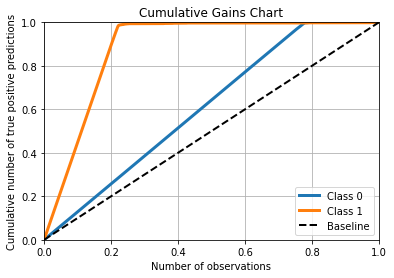

In [71]:
Y_true = vectorized_positive_test.select("default payment next month").collect()
test_cred_no_def = vectorized_positive_test.select("temp_features")
Y_pred_df = model_naive_b.transform(test_cred_no_def)
Y_pred_probabilities = Y_pred_df.select("probability").collect()
Y_pred_predictions = Y_pred_df.select("prediction").collect()

Y_pred_probabilities_np = np.array(Y_pred_probabilities)
Y_pred_probabilities_np = np.reshape(Y_pred_probabilities_np, (Y_pred_probabilities_np.shape[0], 2))

print(classification_report(Y_true, Y_pred_predictions))
plot_cumulative_gains(np.array(Y_true), Y_pred_probabilities_np)